# Working with Big Data using Dask

<div class="questions">  
### Questions

- "Use a modern python library and elegant syntax for performance benefits"
- "How do I deal with large irregular data and show me some real world examples of Dask"
</div>

<div class="objectives">  
### Objectives

- "Intro to Dask concepts and High level datastructures"
- "Use dask dataframes"
- "Use dask delayed functions"
- "Deal with semi-structured and unstructured data in memory efficient and parallel manner"
- "Show me examples of using Dask on Large Datasets"
</div>

## DASK
Dask is a flexible library for parallel computing in Python.

Dask is composed of two parts:
Dynamic task scheduling optimized for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads. “Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like ***NumPy, Pandas, or Python iterators*** to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.

Dask emphasizes the following virtues:

* Familiar: Provides parallelized NumPy array and Pandas DataFrame objects
* Flexible: Provides a task scheduling interface for more custom workloads and integration with other projects.
* Native: Enables distributed computing in pure Python with access to the PyData stack.
* Fast: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
* Scales up: Runs resiliently on clusters with 1000s of cores
* Scales down: Trivial to set up and run on a laptop in a single process
* Responsive: Designed with interactive computing in mind, it provides rapid feedback and diagnostics to aid humans

<figure>
  <img src="./fig/dask_pic1.png" style="margin:10px;width:600px"/>
  <figcaption> Dask High Level Schema <a href="https://docs.dask.org/en/latest/">https://docs.dask.org/en/latest/</a></figcaption>
</figure><br>

Dask provides high level collections - these are ***Dask Dataframes, bags, and arrays***.
On a low level, dask dynamic task schedulers to scale up or down processes, and presents parallel computations by implementing task graphs. It provides an alternative to scaling out tasks instead of threading (IO Bound) and multiprocessing (cpu bound).

A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames.

<figure>
  <img src="./fig/dask_pic2.png" style="margin:6px;width:400px"/>
  <figcaption> Dask High Level Schema <a href="https://docs.dask.org/en/latest/dataframe.html/">https://docs.dask.org/en/latest/dataframe.html/</a></figcaption>
</figure><br>

Common Use Cases:
Dask DataFrame is used in situations where Pandas is commonly needed, usually when Pandas fails due to data size or computation speed:
- Manipulating large datasets, even when those datasets don’t fit in memory
- Accelerating long computations by using many cores
- Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

Dask Dataframes **may not be the best choice** if:
your data fits comfortable in RAM - Use pandas only!
If you need a proper database.
You need functions not implemented by dask dataframes - see Dask Delayed.

## Dask Dataframes

We will load in some data to explore.

In [1]:
#Import dask dataframe modules
import dask.dataframe as dd

#NOTE: to run this example (with diagrams) you will need to "pip install graphviz" and donwload graphviz
#https://graphviz.org/download/
import os
os.environ["PATH"] += os.pathsep + 'C:/APPS/Graphviz/bin'

In [2]:
# Setup a parlalle LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:54234 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.21 GB


In [3]:
# Although this is small csv file, we'll reuse our same example from before!
# Load csv results from server into a Pandas DataFrame
df = dd.read_csv("../data/ml_data_points.csv")

In [4]:
# We only see the metadata, the actual data are only computed when requested.
df

,Unnamed: 0,0 Present day longitude (degrees),1 Present day latitude (degrees),2 Reconstructed longitude (degrees),3 Reconstructed latitude (degrees),4 Age (Ma),5 Time before mineralisation (Myr),6 Seafloor age (Myr),7 Segment length (km),8 Slab length (km),9 Distance to trench edge (km),10 Subducting plate normal velocity (km/Myr),11 Subducting plate parallel velocity (km/Myr),12 Overriding plate normal velocity (km/Myr),13 Overriding plate parallel velocity (km/Myr),14 Convergence normal rate (km/Myr),15 Convergence parallel rate (km/Myr),16 Subduction polarity (degrees),17 Subduction obliquity (degrees),18 Distance along margin (km),19 Subduction obliquity signed (radians),20 Ore Deposits Binary Flag (1 or 0)
npartitions=1,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


The concept of splitting the dask dataframe into pandas sub dataframes can be seen by the ***nopartitians=10*** output. This is the number of partitians the dataframe is split into and in this case was automatically calibrated, but can be specified. There is a trade off between splitting data too much that improves memory management, and the number of extra tasks it generates. For instance, if you have a 1000 GB of data and are using 10 MB chunks, then you have 100,000 partitions. Every operation on such a collection will generate at least 100,000 tasks. But more on this later. For now lets become familiar with some basic Dataframe operations.

Let's inspect the data in its types, and also take the first 5 rows. 

By default, dataframe operations are ***lazy*** meaning no computation takes place until specified. The ***.compute()*** triggers such a computation - and we will see later on that it converts a dask dataframe into a pandas dataframe. ***head(rows)*** also triggers a computation - but is really helpful in exploring the underlying data.

In [5]:
df.head(5)

,Unnamed: 0,0 Present day longitude (degrees),1 Present day latitude (degrees),2 Reconstructed longitude (degrees),3 Reconstructed latitude (degrees),4 Age (Ma),5 Time before mineralisation (Myr),6 Seafloor age (Myr),7 Segment length (km),8 Slab length (km),...,11 Subducting plate parallel velocity (km/Myr),12 Overriding plate normal velocity (km/Myr),13 Overriding plate parallel velocity (km/Myr),14 Convergence normal rate (km/Myr),15 Convergence parallel rate (km/Myr),16 Subduction polarity (degrees),17 Subduction obliquity (degrees),18 Distance along margin (km),19 Subduction obliquity signed (radians),20 Ore Deposits Binary Flag (1 or 0)
0,0,-66.28,-27.37,-65.264812,-28.103781,6.0,0.0,48.189707,56.08069,2436.30907,...,40.63020,-17.43987,12.20271,102.31471,28.82518,5.67505,15.73415,2269.19769,0.274613,1.0
1,1,-69.75,-30.50,-67.696759,-31.970639,12.0,0.0,52.321162,56.09672,2490.68735,...,39.60199,-22.80622,13.40127,115.35820,27.39401,5.78937,13.35854,1823.34107,0.233151,1.0
2,2,-66.65,-27.27,-65.128689,-28.374772,9.0,0.0,53.506085,55.77705,2823.54951,...,45.32425,-18.08485,11.27500,100.24282,34.62444,8.97218,19.05520,2269.19769,0.332576,1.0
3,3,-66.61,-27.33,-65.257928,-28.311094,8.0,0.0,51.317135,55.90088,2656.71724,...,43.13319,-17.78538,11.72618,101.21965,31.92962,7.42992,17.50782,2269.19769,0.305569,1.0
4,4,-66.55,-27.40,-65.366917,-28.257580,7.0,0.0,49.340097,56.09011,2547.29585,...,40.57322,-17.43622,12.23778,102.25748,28.80235,5.65657,15.73067,2269.19769,0.274552,1.0


In [6]:
df.columns

Index(['Unnamed: 0', '0 Present day longitude (degrees)',
       '1 Present day latitude (degrees)',
       '2 Reconstructed longitude (degrees)',
       '3 Reconstructed latitude (degrees)', '4 Age (Ma)',
       '5 Time before mineralisation (Myr)', '6 Seafloor age (Myr)',
       '7 Segment length (km)', '8 Slab length (km)',
       '9 Distance to trench edge (km)',
       '10 Subducting plate normal velocity (km/Myr)',
       '11 Subducting plate parallel velocity (km/Myr)',
       '12 Overriding plate normal velocity (km/Myr)',
       '13 Overriding plate parallel velocity (km/Myr)',
       '14 Convergence normal rate (km/Myr)',
       '15 Convergence parallel rate (km/Myr)',
       '16 Subduction polarity (degrees)', '17 Subduction obliquity (degrees)',
       '18 Distance along margin (km)',
       '19 Subduction obliquity signed (radians)',
       '20 Ore Deposits Binary Flag (1 or 0)'],
      dtype='object')

In [7]:
#You can run typical pandas operations (generally faster! - but only noticeable on large data)
#group by operation - calculate the convergence rate by age. 
#Notice the compute() trigger that performs the operations.
#df.groupby('4 Age (Ma)')['14 Convergence normal rate (km/Myr)'].mean()
df.groupby('4 Age (Ma)')['14 Convergence normal rate (km/Myr)'].mean().compute()

4 Age (Ma)
1.0      66.594390
3.0      86.227770
4.0      76.746980
5.0      86.430612
6.0      96.153738
           ...    
175.0    30.189475
176.0    26.693450
177.0    15.504740
178.0    58.860860
179.0    65.671240
Name: 14 Convergence normal rate (km/Myr), Length: 126, dtype: float64

# We can break up the table into 4 partions to map out to each core:
df = df.repartition(npartitions=4)
df

In [8]:
# Let's say we want to know the minimum last eruption year for all volcanoes
last_eruption_year_min = df['4 Age (Ma)'].mean()
last_eruption_year_min

dd.Scalar<series-..., dtype=float64>

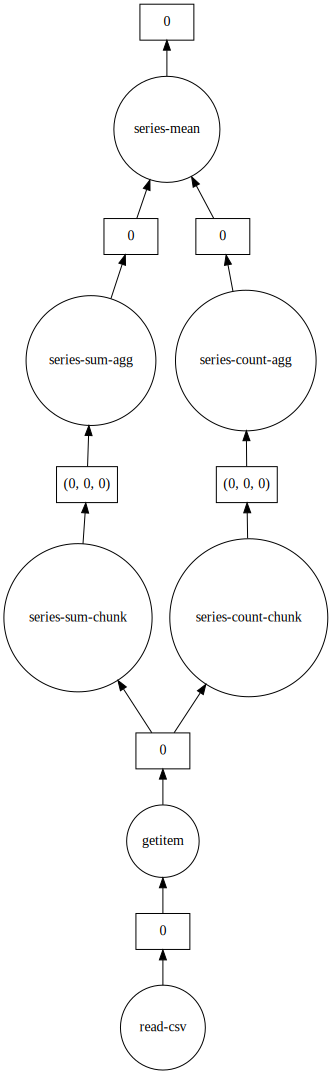

In [9]:
# Instead of getting the actual value we see dd.Scalar, which represents a recipe for actually calculating this value
last_eruption_year_min.visualize(format='svg')

In [10]:
# To get the value call the 'compute method'
# NOTE: this was slower than using pandas directly,,, for small data you often don't need to use parallel computing!
last_eruption_year_min.compute()

66.19601328903654

In [11]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [12]:
print('%.1f MB' % (ones_np.nbytes / 1e6))

32.0 MB


In [13]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [14]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [15]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

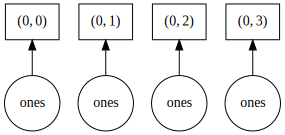

In [16]:
ones.visualize(format='svg')

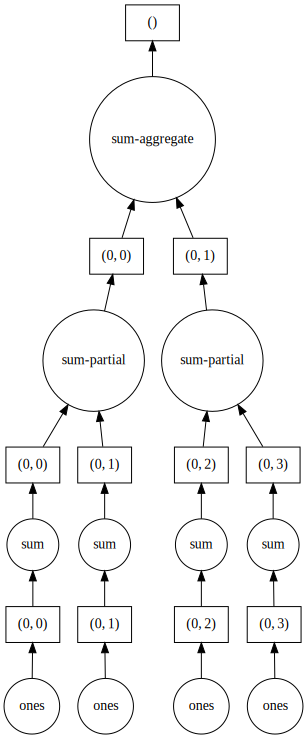

In [17]:
sum_of_ones = ones.sum()
sum_of_ones.visualize(format='svg')

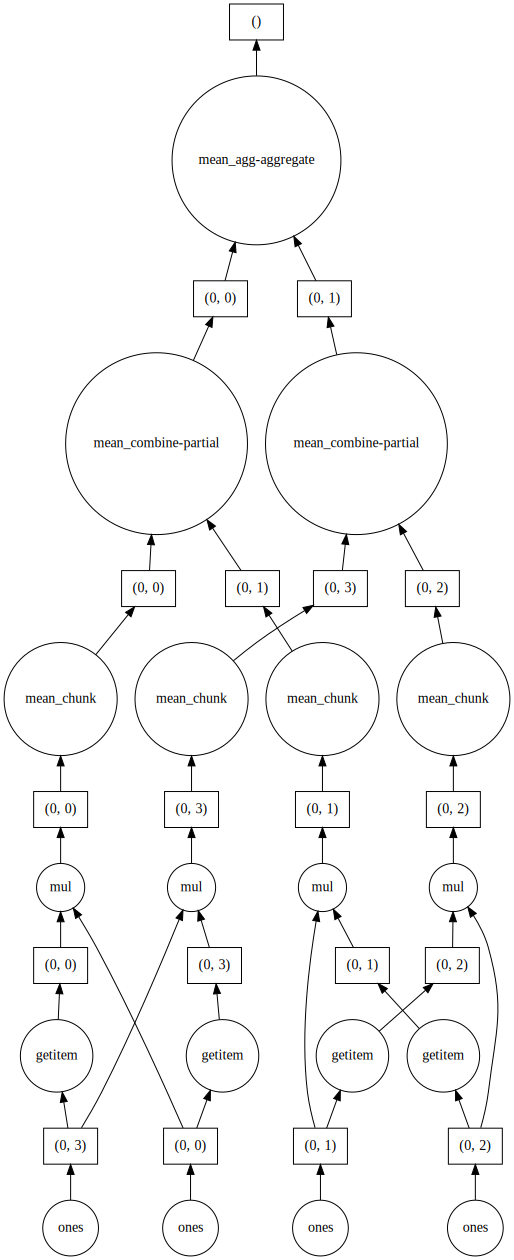

In [18]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize(format='svg')

In [19]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [20]:
print('%.1f MB' % (big_ones.nbytes / 1e6))

6400.0 MB


In [21]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

result = big_calc.compute()
result

1.0

In [22]:
import time

def inc(x):
    time.sleep(0.1)
    return x + 1

def dec(x):
    time.sleep(0.1)
    return x - 1

def add(x, y):
    time.sleep(0.2)
    return x + y

In [23]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

Wall time: 431 ms


3

In [24]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

In [25]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

Wall time: 1.03 ms


Delayed('add-4336c3e8-9b9a-47b3-8c33-5da47dd0128c')

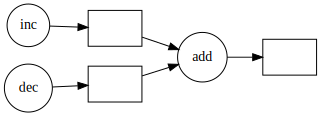

In [26]:
z.visualize(format='svg', rankdir='LR')

In [27]:
%%time
z.compute()

Wall time: 363 ms


3

## Helpful Links:

Dask bag fundamentals
[https://docs.dask.org/en/latest/bag.html](https://docs.dask.org/en/latest/bag.html)

Bag API's:
[https://docs.dask.org/en/latest/bag-api.html](https://docs.dask.org/en/latest/bag.html)

Dask bag limitations:
[https://docs.dask.org/en/latest/shared.html](https://docs.dask.org/en/latest/bag.html)

Pangeo info:
[https://pangeo.io/#what-is-pangeo](https://pangeo.io/#what-is-pangeo)

Xarray:
[http://xarray.pydata.org/en/stable/](http://xarray.pydata.org/en/stable/)

Xarray API:
[http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)

Dask Dataframe intro
[https://docs.dask.org/en/latest/dataframe.html](https://docs.dask.org/en/latest/dataframe.html)

API list for Dask Dataframes
[https://docs.dask.org/en/latest/dataframe.html](https://docs.dask.org/en/latest/dataframe-api.html)

What are decorators
[https://realpython.com/primer-on-python-decorators/](https://realpython.com/primer-on-python-decorators/)


<div class="keypoints">  
### Key Points

- "Dask builds on numpy and pandas APIs but operates in a parallel manner"
- "Computations are by default lazy and must be triggered - this reduces unneccessary computation time"
- "Dask Bag uses map filter and group by operations on python objects or semi/unstrucutred data"
- "dask.multiprocessing is under the hood"
- "Xarray is another option for holding netcdf data"
</div>